In [ ]:
# pip install ydata-profiling

In [2]:
import pandas as pd
# from ydata_profiling import ProfileReport

In [3]:


# Read file
df_sales_train = pd.read_csv('/content/train.csv')
df_sales_test = pd.read_csv('/content/test.csv')

df_sales_train['split'] = 'train'
df_sales_test['split'] = 'test'
df_sales_test['Item_Outlet_Sales'] = 0


df_all=pd.concat([df_sales_train,df_sales_test])
display(df_all.tail())
# df_sales_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
5676,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,0.0,test
5677,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.0,test
5678,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test
5679,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,0.0,test
5680,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.0,test


In [4]:
# df_sales_train

df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].str.strip().str.lower().str.replace(' ', '')

df_all["Item_Fat_Content"] = df_all["Item_Fat_Content"].replace({
    "lf": "low fat",
    "reg": "regular"
})

In [5]:
# Calculate the mean Item_Weight for each Item_Identifier, excluding NaNs
mean_item_weight = df_all.groupby('Item_Identifier')['Item_Weight'].mean()

# Fill NaN values in Item_Weight based on the calculated mean for each Item_Identifier
df_all['Item_Weight'] = df_all['Item_Weight'].fillna(df_all['Item_Identifier'].map(mean_item_weight))

# Display the count of remaining NaN values in Item_Weight to confirm imputation
print(f"Remaining NaN values in 'Item_Weight' after imputation: {df_all['Item_Weight'].isnull().sum()}")
display(df_all.head())

Remaining NaN values in 'Item_Weight' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [6]:
df_sales_train['Item_Weight'].isnull().sum()

np.int64(1463)

In [7]:
sales_and_outlet_stats = df_all.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type','Outlet_Identifier','Outlet_Establishment_Year'], dropna=False).agg(
    total_item_sales=('Item_Outlet_Sales', 'sum'),
    distinct_outlets=('Outlet_Identifier', 'nunique'),
    distinct_item=('Item_Identifier', 'nunique'),
).reset_index()
display(sales_and_outlet_stats)

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Outlet_Establishment_Year,total_item_sales,distinct_outlets,distinct_item
0,High,Tier 3,Supermarket Type1,OUT013,1987,2.142664e+06,1,1553
1,Medium,Tier 1,Supermarket Type1,OUT049,1999,2.183970e+06,1,1550
2,Medium,Tier 3,Supermarket Type2,OUT018,2009,1.851823e+06,1,1546
3,Medium,Tier 3,Supermarket Type3,OUT027,1985,3.453926e+06,1,1559
4,Small,Tier 1,Grocery Store,OUT019,1985,1.796941e+05,1,880
5,Small,Tier 1,Supermarket Type1,OUT046,1997,2.118395e+06,1,1550
6,Small,Tier 2,Supermarket Type1,OUT035,2004,2.268123e+06,1,1550
7,NaN,Tier 2,Supermarket Type1,OUT017,2007,2.167465e+06,1,1543
8,NaN,Tier 2,Supermarket Type1,OUT045,2002,2.036725e+06,1,1548
9,NaN,Tier 3,Grocery Store,OUT010,1998,1.883402e+05,1,925


In [8]:
df_all['Outlet_Size']=df_all['Outlet_Size'].fillna('Small')

In [9]:
# Calculate mean Item_Visibility for each Item_Type where visibility is not zero
mean_visibility_by_item_type = df_all[df_all['Item_Visibility'] != 0].groupby('Item_Type')['Item_Visibility'].mean()

# Create a copy of Item_Visibility for masking
df_all['Item_Visibility_masked'] = df_all['Item_Visibility'].copy()

# Identify rows where Item_Visibility is 0
zero_visibility_mask = df_all['Item_Visibility_masked'] == 0

# Impute 0 values with the mean visibility for their respective Item_Type
df_all.loc[zero_visibility_mask, 'Item_Visibility_masked'] = df_all.loc[zero_visibility_mask, 'Item_Type'].map(mean_visibility_by_item_type)

# Verify that there are no more 0 values (or very few if some Item_Types had only 0 visibility originally)
print(f"Number of 0 values in 'Item_Visibility_masked' after imputation: {(df_all['Item_Visibility_masked'] == 0).sum()}")
display(df_all.head())

Number of 0 values in 'Item_Visibility_masked' after imputation: 0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186


In [10]:
# feature creation
import datetime
df_all['Current_Year'] = datetime.datetime.now().year
df_all['Outlet_Age'] = df_all['Current_Year'] - df_all['Outlet_Establishment_Year']

In [11]:
train_outlet_avg_sales = df_all[df_all['split'] == 'train'].groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean()
df_all['Outlet_Average_Sales'] = df_all['Outlet_Identifier'].map(train_outlet_avg_sales)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256


In [12]:
(df_all['Outlet_Average_Sales'] == 0).sum()

np.int64(0)

In [13]:
df_all['item_category'] = df_all['Item_Identifier'].str.slice(0, 2)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC


In [14]:
outlet_item_count = df_all.groupby('Outlet_Identifier')['Item_Identifier'].nunique().reset_index()
outlet_item_count.rename(columns={'Item_Identifier': 'Outlet_Item_Count'}, inplace=True)
df_all = pd.merge(df_all, outlet_item_count, on='Outlet_Identifier', how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553


In [15]:
item_cat_avg_sales_per_outlet = df_all[df_all['split'] == 'train'].groupby(['Outlet_Identifier', 'item_category'])['Item_Outlet_Sales'].mean().reset_index()
item_cat_avg_sales_per_outlet = item_cat_avg_sales_per_outlet.rename(columns={'Item_Outlet_Sales': 'Item_cat_Avg_Sales_Per_Outlet'})
df_all = pd.merge(df_all, item_cat_avg_sales_per_outlet, on=['Outlet_Identifier', 'item_category'], how='left')
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,0.073305,2026,28,339.351662,FD,925,334.778691
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627


In [16]:
df_all['Item_Visibility_Mean'] = df_all.groupby('Item_Identifier')['Item_Visibility'].transform('mean')
df_all['Visibility_Ratio'] = df_all['Item_Visibility'] / df_all['Item_Visibility_Mean']
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,split,Item_Visibility_masked,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,train,0.016047,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,train,0.019278,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,train,0.016760,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,train,0.073305,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,train,0.063186,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000


In [17]:
df_all['Item_Type_cleaned'] = df_all['Item_Type'].str.strip().str.lower().str.replace(' ', '')

def item_type_grouper(item_type):
    if item_type in [
        'fruitsandvegetables', 'snackfoods', 'household', 'frozenfoods',
        'dairy', 'canned', 'bakinggoods', 'healthandhygiene', 'softdrinks', 'meat'
    ]:
        return item_type
    else:
        return 'others'

df_all['item_type_grouped'] = df_all['Item_Type_cleaned'].apply(item_type_grouper)
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Current_Year,Outlet_Age,Outlet_Average_Sales,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,2026,17,1995.498739,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2026,27,2348.354635,FD,1550,2337.653479,0.017457,0.960069,meat,meat
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,2026,28,339.351662,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2026,39,2298.995256,NC,1553,2235.667627,0.009780,0.000000,household,household


In [18]:
df_all['Outlet_Type_cleaned'] = df_all['Outlet_Type'].str.strip().str.lower().str.replace(' ', '')

In [19]:
df_all['Outlet_Location_Type_cleaned'] = df_all['Outlet_Location_Type'].str.strip().str.lower().str.replace(' ', '')

In [20]:
df_all['item_price_bucket'] = pd.qcut(df_all['Item_MRP'], q=4, labels=['Low', 'Med', 'High', 'Premium'])

item_price_map = {'Low': 1, 'Med': 2, 'High': 3, 'Premium': 4}
df_all['item_price_bucket'] = df_all['item_price_bucket'].map(item_price_map)

display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,item_category,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,DR,1546,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,FD,1550,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,FD,925,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,NC,1553,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1


In [21]:
outlet_mean = df_all[df_all['split'] == 'train'].groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

df_all["Outlet_Type_TE"] = df_all["Outlet_Type"].map(outlet_mean)

df_all["MRP_x_OutletType"] = df_all["Item_MRP"] * df_all["Outlet_Type_TE"]
display(df_all.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Item_cat_Avg_Sales_Per_Outlet,Item_Visibility_Mean,Visibility_Ratio,Item_Type_cleaned,item_type_grouped,Outlet_Type_cleaned,Outlet_Location_Type_cleaned,item_price_bucket,Outlet_Type_TE,MRP_x_OutletType
0,FDA15,9.30,lowfat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017235,0.931078,dairy,dairy,supermarkettype1,tier1,4,2316.181148,578603.359664
1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,1907.604188,0.020653,0.933420,softdrinks,softdrinks,supermarkettype2,tier3,1,1995.498739,96321.127743
2,FDN15,17.50,lowfat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,2337.653479,0.017457,0.960069,meat,meat,supermarkettype1,tier1,2,2316.181148,328012.941833
3,FDX07,19.20,regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,334.778691,0.017834,0.000000,fruitsandvegetables,fruitsandvegetables,grocerystore,tier3,3,339.828500,61881.070792
4,NCD19,8.93,lowfat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,...,2235.667627,0.009780,0.000000,household,household,supermarkettype1,tier3,1,2316.181148,124752.759291


In [22]:
# Nonlinear price
df_all["MRP_squared"] = df_all["Item_MRP"] ** 2

In [23]:
import numpy as np

In [24]:
df_all["MRP_log"] = np.log1p(df_all["Item_MRP"])
df_all["MRP_x_OutletAvg"] = df_all["Item_MRP"] * df_all["Outlet_Average_Sales"]

In [26]:
df_all.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'split', 'Item_Visibility_masked',
       'Current_Year', 'Outlet_Age', 'Outlet_Average_Sales', 'item_category',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Visibility_Mean', 'Visibility_Ratio', 'Item_Type_cleaned',
       'item_type_grouped', 'Outlet_Type_cleaned',
       'Outlet_Location_Type_cleaned', 'item_price_bucket', 'Outlet_Type_TE',
       'MRP_x_OutletType', 'MRP_squared', 'MRP_log', 'MRP_x_OutletAvg'],
      dtype='object')

In [25]:
df_all_filtered = df_all.copy()

# Define ordinal mapping for Outlet_Size
outlet_size_map = {'Small': 0, 'Medium': 1, 'High': 2}
df_all_filtered['Outlet_Size'] = df_all_filtered['Outlet_Size'].map(outlet_size_map)

fat_map = {'lowfat': 0, 'regular': 1}
df_all_filtered['Item_Fat_Content'] = df_all_filtered['Item_Fat_Content'].map(fat_map)

# Select the final set of features for the model, now with ordinally encoded Outlet_Size
df_all_filtered = df_all_filtered[['Item_Identifier', 'Item_Weight', 'Visibility_Ratio',
         'Outlet_Identifier', 'Outlet_Age',
        'Outlet_Type_cleaned','item_category',
       'split', 'Outlet_Average_Sales',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet',
       'Item_Outlet_Sales','Item_MRP']]

      #  'Outlet_Location_Type_cleaned', 'Item_Fat_Content','item_type_grouped', 'Outlet_Size','','MRP_x_OutletType,,'MRP_squared'
      # ,'Item_MRP','MRP_log'

display(df_all_filtered.head())

,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,Outlet_Type_cleaned,item_category,split,Outlet_Average_Sales,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP
0,FDA15,9.30,0.931078,OUT049,27,supermarkettype1,FD,train,2348.354635,1550,2337.653479,3735.1380,249.8092
1,DRC01,5.92,0.933420,OUT018,17,supermarkettype2,DR,train,1995.498739,1546,1907.604188,443.4228,48.2692
2,FDN15,17.50,0.960069,OUT049,27,supermarkettype1,FD,train,2348.354635,1550,2337.653479,2097.2700,141.6180
3,FDX07,19.20,0.000000,OUT010,28,grocerystore,FD,train,339.351662,925,334.778691,732.3800,182.0950
4,NCD19,8.93,0.000000,OUT013,39,supermarkettype1,NC,train,2298.995256,1553,2235.667627,994.7052,53.8614


In [27]:

# removed cat var

categorical_cols = [  'Outlet_Type_cleaned','item_category',]
# , 'Outlet_Location_Type_cleaned','item_type_grouped', 'item_category'
# Apply one-hot encoding
df_all_filtered = pd.get_dummies(df_all_filtered, columns=categorical_cols, dtype=int)
print(f"Shape of DataFrame after one-hot encoding: {df_all_filtered.shape}")
display(df_all_filtered.head())

Shape of DataFrame after one-hot encoding: (14204, 18)


,Item_Identifier,Item_Weight,Visibility_Ratio,Outlet_Identifier,Outlet_Age,split,Outlet_Average_Sales,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_Outlet_Sales,Item_MRP,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
0,FDA15,9.30,0.931078,OUT049,27,train,2348.354635,1550,2337.653479,3735.1380,249.8092,0,1,0,0,0,1,0
1,DRC01,5.92,0.933420,OUT018,17,train,1995.498739,1546,1907.604188,443.4228,48.2692,0,0,1,0,1,0,0
2,FDN15,17.50,0.960069,OUT049,27,train,2348.354635,1550,2337.653479,2097.2700,141.6180,0,1,0,0,0,1,0
3,FDX07,19.20,0.000000,OUT010,28,train,339.351662,925,334.778691,732.3800,182.0950,1,0,0,0,0,1,0
4,NCD19,8.93,0.000000,OUT013,39,train,2298.995256,1553,2235.667627,994.7052,53.8614,0,1,0,0,0,0,1


In [ ]:
# outlet_cols = [col for col in df_all_filtered.columns if "Outlet_Type_" in col]

# for col in outlet_cols:
#     df_all_filtered[f"MRP_x_{col}"] = df_all_filtered["Item_MRP"] * df_all_filtered[col]

In [28]:
# Remove the 'test' split data
df_train_only = df_all_filtered[df_all_filtered['split'] == 'train'].copy()

# Drop the 'split' column as it's no longer needed after filtering
df_train_only = df_train_only.drop(columns=['split'])

# Define features (X) and target (y)
X = df_train_only.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
y = df_train_only['Item_Outlet_Sales']

print(f"Shape of features (X) before split: {X.shape}")
print(f"Shape of target (y) before split: {y.shape}")

Shape of features (X) before split: (8523, 14)
Shape of target (y) before split: (8523,)


In [29]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (6818, 14)
Shape of X_test: (1705, 14)
Shape of y_train: (6818,)
Shape of y_test: (1705,)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler ONLY on X_train and then transform X_train
X_train[['Item_Weight']] = scaler.fit_transform(X_train[['Item_Weight']])
# X_train[['Item_Weight','Item_MRP']] = scaler.fit_transform(X_train[['Item_Weight','Item_MRP']])

# Transform X_test using the SAME scaler fitted on X_train
X_test[['Item_Weight']] = scaler.transform(X_test[['Item_Weight']])

print("Item_Weight and Item_MRP scaled for both X_train and X_test.")
display(X_train.head())
display(X_test.head())

# '','MRP_x_OutletType,,'MRP_squared',,'Item_MRP'

Item_Weight and Item_MRP scaled for both X_train and X_test.


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Average_Sales,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
549,-0.733372,0.931078,27,2348.354635,1550,2337.653479,171.3448,0,1,0,0,0,1,0
7757,1.096529,0.876503,24,2192.384798,1548,2110.486513,170.5422,0,1,0,0,0,0,1
764,1.010416,0.874729,29,2277.844267,1550,2355.754278,111.7202,0,1,0,0,0,1,0
6867,-0.986329,0.931518,24,2192.384798,1548,2222.594278,41.6138,0,1,0,0,0,1,0
2716,-0.012176,1.027572,29,2277.844267,1550,2355.754278,155.5630,0,1,0,0,0,1,0


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Average_Sales,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
7503,0.299984,0.928859,39,2298.995256,1553,2326.618577,79.4302,0,1,0,0,0,1,0
2957,-1.071366,0.929633,29,2277.844267,1550,2178.177575,42.7086,0,1,0,0,0,0,1
7031,0.343040,0.960444,27,2348.354635,1550,2337.653479,42.0454,0,1,0,0,0,1,0
1084,0.020117,0.953860,41,3694.038558,1559,3294.133992,173.7054,0,0,0,1,1,0,0
856,-0.583751,0.922116,22,2438.841866,1550,2454.513189,197.5110,0,1,0,0,0,1,0


In [ ]:


# calculate 99th percentile from training target
# cap_value = np.percentile(y_train, 99)
# y_train_capped = np.clip(y_train, None, cap_value)
# y_test_capped = np.clip(y_test, None, cap_value)

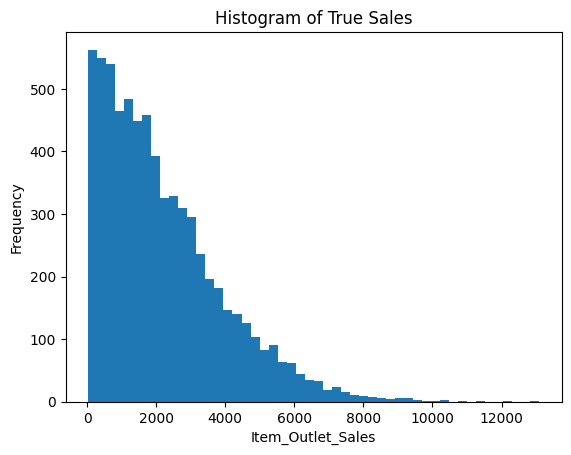

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(y_train, bins=50)
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.title("Histogram of True Sales")
plt.show()

In [ ]:
# import numpy as np

# y_train_log = np.log1p(y_train)
# y_test_log = np.log1p(y_test)



Finalprediction data prep

In [32]:
# Filter df_all_filtered to get the test split data
df_test_final = df_all_filtered[df_all_filtered['split'] == 'test'].copy()

# Prepare features for prediction, similar to how X_train was created
# Drop 'Item_Outlet_Sales' (since it's all 0 for test), 'Item_Identifier', 'Outlet_Identifier', and 'split'
X_final_test = df_test_final.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier', 'split'])

# Ensure the columns are in the same order as X_train
X_final_test = X_final_test[X_train.columns] # Use X_train.columns to match order and selected features

# Apply the SAME scaler fitted on X_train to the 'Item_Weight' and 'Item_MRP' of the test data
X_final_test[['Item_Weight']] = scaler.transform(X_final_test[['Item_Weight']])

print(f"Shape of final test features for prediction: {X_final_test.shape}")
display(X_final_test.head())


# '','MRP_x_OutletType,'MRP_squared',,'Item_MRP'

Shape of final test features for prediction: (5681, 14)


,Item_Weight,Visibility_Ratio,Outlet_Age,Outlet_Average_Sales,Outlet_Item_Count,Item_cat_Avg_Sales_Per_Outlet,Item_MRP,Outlet_Type_cleaned_grocerystore,Outlet_Type_cleaned_supermarkettype1,Outlet_Type_cleaned_supermarkettype2,Outlet_Type_cleaned_supermarkettype3,item_category_DR,item_category_FD,item_category_NC
8523,1.688556,1.029192,27,2348.354635,1550,2337.653479,107.8622,0,1,0,0,0,1,0
8524,-0.991712,1.130311,19,2340.675263,1543,2370.972871,87.3198,0,1,0,0,0,1,0
8525,0.364569,1.735215,28,339.351662,925,371.726653,241.7538,1,0,0,0,0,0,1
8526,-1.203765,1.291577,19,2340.675263,1543,2370.972871,155.0340,0,1,0,0,0,1,0
8527,0.149286,0.917824,41,3694.038558,1559,3776.820790,234.2300,0,0,0,1,0,1,0


In [33]:
X_final_test.columns

Index(['Item_Weight', 'Visibility_Ratio', 'Outlet_Age', 'Outlet_Average_Sales',
       'Outlet_Item_Count', 'Item_cat_Avg_Sales_Per_Outlet', 'Item_MRP',
       'Outlet_Type_cleaned_grocerystore',
       'Outlet_Type_cleaned_supermarkettype1',
       'Outlet_Type_cleaned_supermarkettype2',
       'Outlet_Type_cleaned_supermarkettype3', 'item_category_DR',
       'item_category_FD', 'item_category_NC'],
      dtype='object')

In [50]:
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(X))
oof_rf = np.zeros(len(X))

for train_idx, val_idx in kf.split(X):

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # LightGBM
    lgb_model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=3000,
        learning_rate=0.01,
        num_leaves=40,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=56
    )
    lgb_model.fit(X_tr, y_tr)
    oof_lgb[val_idx] = lgb_model.predict(X_val)

    # RandomForest
    rf_model = RandomForestRegressor(
        n_estimators=600,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=78,
        n_jobs=-1
    )
    rf_model.fit(X_tr, y_tr)
    oof_rf[val_idx] = rf_model.predict(X_val)

    meta_X = np.column_stack((oof_lgb, oof_rf))

# meta_model = Ridge(alpha=1.0)
meta_model = Ridge(alpha=9.0)
meta_model.fit(meta_X, y)

stack_pred = meta_model.predict(meta_X)

rmse_stack = np.sqrt(mean_squared_error(y, stack_pred))
print("Stacked CV RMSE:", rmse_stack)

lgb_full = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=3000,
    learning_rate=0.01,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=32
)
lgb_full.fit(X, y)

rf_full = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=67,
    n_jobs=-1
)
rf_full.fit(X, y)

pred_lgb_test = lgb_full.predict(X_test)
pred_rf_test = rf_full.predict(X_test)

meta_test_X = np.column_stack((pred_lgb_test, pred_rf_test))
final_test_pred = meta_model.predict(meta_test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 14
[LightGBM] [Info] Start training from score 2202.365232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [51]:
np.corrcoef(pred_lgb_test, pred_rf_test)

array([[1.        , 0.96242868],
       [0.96242868, 1.        ]])

In [52]:
final_test_pred = meta_model.predict(meta_test_X)

In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))
print("Stacked Test RMSE:", rmse)

Stacked Test RMSE: 928.7030956768319


In [54]:
pred_lgb_test_f = lgb_full.predict(X_final_test)
pred_rf_test_f = rf_full.predict(X_final_test)
meta_test_X = np.column_stack((pred_lgb_test_f, pred_rf_test_f))

# print("Predictions for the test dataset using meta_model:")
# display(pd.Series(meta_test_X).head())

In [55]:
final_test_pred = meta_model.predict(meta_test_X)
print("Predictions for the test dataset using meta_model:")
display(pd.Series(final_test_pred).head())

Predictions for the test dataset using meta_model:


,0
0,2159.359306
1,1542.529951
2,703.736865
3,2470.583856
4,4769.331535


In [46]:
print("Min prediction:", final_test_pred.min())
print("Max prediction:", final_test_pred.max())

Min prediction: 137.95034060193586
Max prediction: 5811.410789313388


In [56]:
submission_df_rf = pd.DataFrame({
    'Item_Identifier': df_test_final['Item_Identifier'],
    'Outlet_Identifier': df_test_final['Outlet_Identifier'],
    'Item_Outlet_Sales': final_test_pred
})

display(submission_df_rf.head())

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,OUT049,2159.359306
8524,FDW14,OUT017,1542.529951
8525,NCN55,OUT010,703.736865
8526,FDQ58,OUT017,2470.583856
8527,FDY38,OUT027,4769.331535


In [48]:
submission_df_rf.to_csv('submission_random_forest_meta.csv', index=False)
print("submission_random_forest_meta.csv has been saved.")

submission_random_forest_meta.csv has been saved.
